In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import keras
import tensorflow as tf
import cv2
import os
import sklearn

In [2]:
import pathlib 
cancer_dir = pathlib.Path("data/unhealthy")
normal_dir = pathlib.Path("data/healthy")

In [3]:
dirlist=[cancer_dir,normal_dir ]
classes=['No', 'Yes']
filepaths=[]
labels=[]
for i,j in zip(dirlist, classes):
    filelist=os.listdir(i)
    for f in filelist:
        filepath=os.path.join (i,f)
        filepaths.append(filepath)
        labels.append(j)
print ('filepaths: ', len(filepaths), '   labels: ', len(labels))

filepaths:  6512    labels:  6512


In [4]:
Files=pd.Series(filepaths, name='filepaths')
Label=pd.Series(labels, name='labels')
df=pd.concat([Files,Label], axis=1)
df=pd.DataFrame(np.array(df).reshape(6512,2), columns = ['filepaths', 'labels'])
df.head()

,filepaths,labels
0,data\unhealthy\WBC-Malignant-Early-001.jpg,No
1,data\unhealthy\WBC-Malignant-Early-002.jpg,No
2,data\unhealthy\WBC-Malignant-Early-003.jpg,No
3,data\unhealthy\WBC-Malignant-Early-004.jpg,No
4,data\unhealthy\WBC-Malignant-Early-005.jpg,No


In [5]:
print(df['labels'].value_counts())

labels
No     5504
Yes    1008
Name: count, dtype: int64


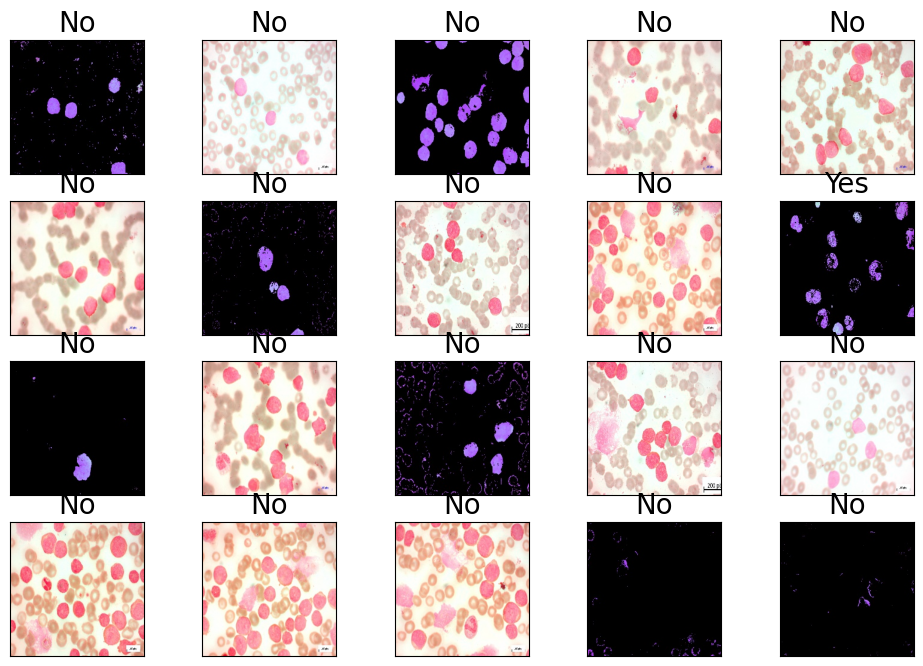

In [6]:
plt.figure(figsize=(12,8))
for i in range(20):
    random = np.random.randint(1,len(df))
    plt.subplot(4,5,i+1)
    plt.imshow(cv2.imread(df.loc[random,"filepaths"]))
    plt.title(df.loc[random, "labels"], size = 20, color = "white") 
    plt.xticks([])
    plt.yticks([])
    
plt.show()

In [7]:
labels = ['CANCER', 'NORMAL']
img_size = 150
def get_training_data(data_dir):
    data = []
    for label in labels: 
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                resized_arr = cv2.resize(img_arr, (img_size, img_size))
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data)

In [8]:
import glob
images_dict = {
    'cancer': list(cancer_dir.glob('*')) ,   
    'normal': list(normal_dir.glob('*'))  
}

labels_dict = {
    'cancer': "cancer",
    'normal': "normal",
    
}

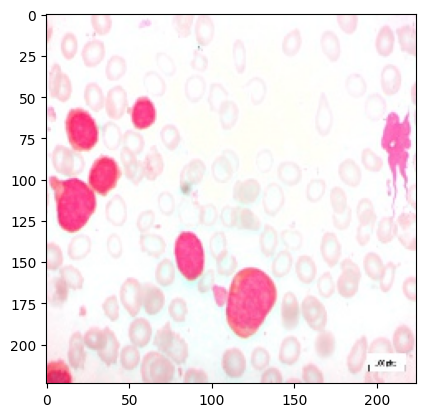

In [9]:
import PIL.Image as Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
img = cv2.imread(str(images_dict['normal'][0]))
plt.imshow(img)


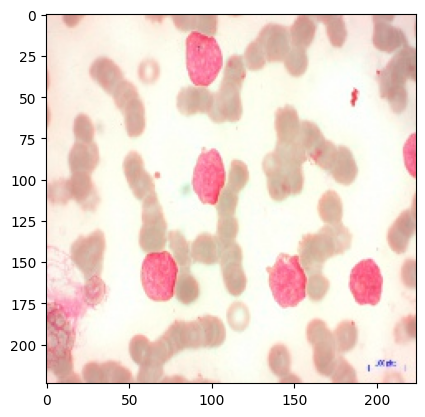

In [10]:
img2 = cv2.imread(str(images_dict['cancer'][0]))
plt.imshow(img2)

In [11]:
X, y = [], []
for name,images in images_dict.items():
    for image in images:
        img=str(image)
        
        X.append(img)
        y.append(labels_dict[name])

In [12]:
Fseries = pd.Series(X, name="filepaths",dtype=str)
Lseries = pd.Series(y, name="labels",dtype=str)
cancer_data = pd.concat([Fseries,Lseries], axis=1)
cancer_df = pd.DataFrame(cancer_data)

print(cancer_df.head())
print("---------------------")
print(cancer_df["labels"].value_counts())

                                    filepaths  labels
0  data\unhealthy\WBC-Malignant-Early-001.jpg  cancer
1  data\unhealthy\WBC-Malignant-Early-002.jpg  cancer
2  data\unhealthy\WBC-Malignant-Early-003.jpg  cancer
3  data\unhealthy\WBC-Malignant-Early-004.jpg  cancer
4  data\unhealthy\WBC-Malignant-Early-005.jpg  cancer
---------------------
labels
cancer    5504
normal    1008
Name: count, dtype: int64


In [13]:
cancer_df.shape

(6512, 2)

In [14]:
from sklearn.model_selection import train_test_split
train_images, test_images = train_test_split(cancer_df, test_size=0.3, random_state=42)
train_set, val_set = train_test_split(cancer_df, test_size=0.2, random_state=42)

In [15]:
print(train_images.shape)
print(test_images.shape)
print(train_set.shape)
print(val_set.shape)

(4558, 2)
(1954, 2)
(5209, 2)
(1303, 2)


In [16]:
image_gen = ImageDataGenerator(preprocessing_function= tf.keras.applications.mobilenet_v2.preprocess_input)
train = image_gen.flow_from_dataframe(dataframe= train_images,x_col="filepaths",y_col="labels",
                                      target_size=(244,244),
                                      color_mode='rgb',
                                      class_mode="categorical",
                                      batch_size=32,
                                      shuffle=False            
                                     )
test = image_gen.flow_from_dataframe(dataframe= test_images,x_col="filepaths", y_col="labels",
                                     target_size=(244,244),
                                     color_mode='rgb',
                                     class_mode="categorical",
                                     batch_size=32,
                                     shuffle= False
                                    )
val = image_gen.flow_from_dataframe(dataframe= val_set,x_col="filepaths", y_col="labels",
                                    target_size=(244,244),
                                    color_mode= 'rgb',
                                    class_mode="categorical",
                                    batch_size=32,
                                    shuffle=False
                                   )

Found 4558 validated image filenames belonging to 2 classes.
Found 1954 validated image filenames belonging to 2 classes.
Found 1303 validated image filenames belonging to 2 classes.


In [17]:
classes=list(train.class_indices.keys())
print (classes)

['cancer', 'normal']


In [18]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers,losses
cnn= Sequential([
                        
                        layers.Conv2D(filters=32,kernel_size=(3,3),activation='relu',padding='same',input_shape=(244,244,3)),
                        layers.MaxPool2D(pool_size=(2,2)),

                        layers.Conv2D(filters=32,kernel_size=(3,3),activation='relu',padding='same'),
                        layers.MaxPool2D(pool_size=(2,2)),

                        layers.Flatten(),
                        layers.Dense(128, activation='relu'),
                        layers.Dropout(rate=0.3),
                        layers.Dense(64, activation="relu"),
                        layers.Dense(2, activation="sigmoid")

])

c:\Coding\Blood-Cancer-Detection\venv\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [19]:
cnn.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

In [20]:
cnn.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 244, 244, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 122, 122, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 122, 122, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 61, 61, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 119072)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    15,241,344 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,259,874 (58.21 MB)

 Trainable params: 15,259,874 (58.21 MB)

 Non-trainable params: 0 (0.00 B)

In [21]:
History = cnn.fit(train, validation_data= val, epochs=10,verbose=1)

c:\Coding\Blood-Cancer-Detection\venv\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/3
143/143 ━━━━━━━━━━━━━━━━━━━━ 137s 931ms/step - accuracy: 0.7934 - loss: 0.8073 - val_accuracy: 0.8496 - val_loss: 0.3886
Epoch 2/3
143/143 ━━━━━━━━━━━━━━━━━━━━ 116s 812ms/step - accuracy: 0.8443 - loss: 0.3787 - val_accuracy: 0.8565 - val_loss: 0.2998
Epoch 3/3
143/143 ━━━━━━━━━━━━━━━━━━━━ 114s 798ms/step - accuracy: 0.8980 - loss: 0.2490 - val_accuracy: 0.9156 - val_loss: 0.1985


In [22]:
cnn.evaluate(test)

62/62 ━━━━━━━━━━━━━━━━━━━━ 14s 224ms/step - accuracy: 0.9139 - loss: 0.1962


[0.19705426692962646, 0.9191402196884155]

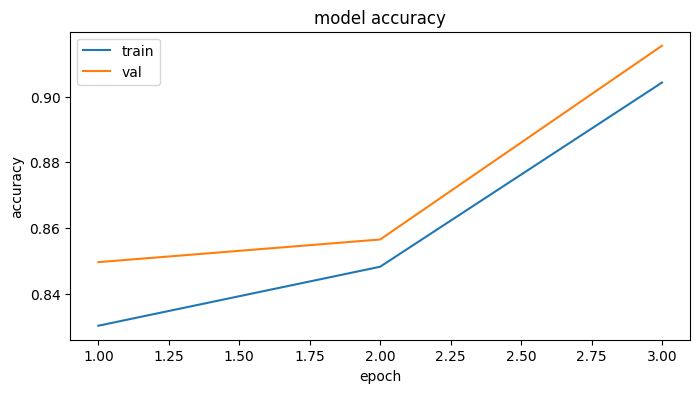

In [23]:
plt.figure(figsize=(8,4))
epochs=range(1,len(History.history['val_accuracy'])+1)

plt.plot(epochs,History.history["accuracy"])
plt.plot(epochs,History.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

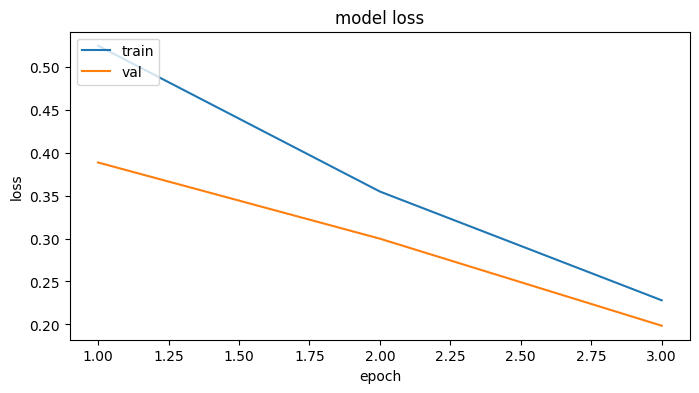

In [24]:
plt.figure(figsize=(8,4))
epochs=range(1,len(History.history['val_loss'])+1)

plt.plot(epochs,History.history["loss"])
plt.plot(epochs,History.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [25]:
predict_classes = np.argmax(cnn.predict(test), axis= -1)

62/62 ━━━━━━━━━━━━━━━━━━━━ 15s 247ms/step


In [26]:
from sklearn.metrics import confusion_matrix
y_list = test_images['labels'].to_list()
y_test = []
for i in range(len(y_list)):
    if y_list[i] == 'normal':
        y_test.append(0)
    else:
        y_test.append(1)
y_test = np.array(y_test)
cm = confusion_matrix(y_test, predict_classes)
cm

array([[ 138,  160],
       [1636,   20]])

In [27]:
cm = pd.DataFrame(cm , index = ['0','1'] , columns = ['0','1'])

<Axes: >

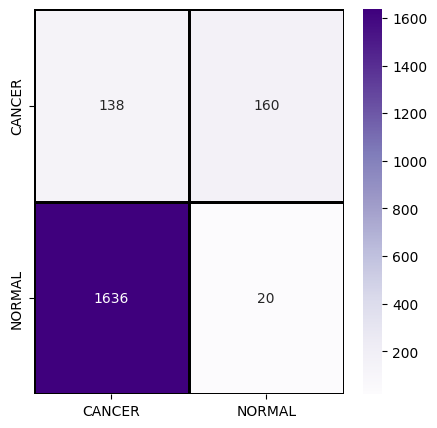

In [28]:
from keras.layers import Dense, Conv2D
plt.figure(figsize = (5,5))
sns.heatmap(cm ,cmap= "Purples", linecolor = 'black' , linewidth = 1 , annot = True, fmt='',xticklabels = labels,yticklabels = labels)

In [29]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np

def predict_image(image_path, model, labels):
    """
    Predict if an image is cancer or normal.

    Parameters:
        image_path (str): Path to the input image.
        model (keras.Model): Trained CNN model.
        labels (list): List of class labels.

    Returns:
        str: Predicted class label.
    """
    img = load_img(image_path, target_size=(244, 244))  
    img_array = img_to_array(img)  
    img_array = np.expand_dims(img_array, axis=0)  
    img_array = tf.keras.applications.mobilenet_v2.preprocess_input(img_array)  
    
    predictions = model.predict(img_array)
    predicted_class = np.argmax(predictions) 

    return labels[predicted_class]

image_path = "data/healthy/WBC-Benign-009.jpg"

predicted_label = predict_image(image_path, cnn, labels)
print(f"The predicted class for the input image is: {predicted_label}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
The predicted class for the input image is: NORMAL


In [ ]:
from sklearn.metrics import roc_curve, auc, roc_auc_score

y_pred_probs = cnn.predict(test)[:, 1] 

fpr, tpr, thresholds = roc_curve(y_test, y_pred_probs)

roc_auc = auc(fpr, tpr)
print(f"AUC Score: {roc_auc:.2f}")

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color="purple", lw=2, label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color="gray", linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()